# Autoencoder Based communication systems

In [340]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

## Hyper‑parameters for input and channel dimentions

In [341]:
k = 10    # bits per message
M = 2**k              # number of possible messages (=> k = log2(M) information bits)
n = 15                 # channel uses (codeword length)
R = k / n              # code rate
training_EbN0_dB = 5   # SNR at which to train (dB)
training_EbN0 = 10 ** (training_EbN0_dB / 10)
sigma_train = np.sqrt(1 / (2 * R * training_EbN0))  # noise std for training

np.random.seed(0)
tf.random.set_seed(0)

In [342]:
# --- Data for training ---
num_train = 40000
labels = np.random.randint(0, M, size=num_train)
one_hot = tf.one_hot(labels, depth=M).numpy()

## power‑normalisation to satisfy E[|x|^2] <= 1

In [343]:
def power_norm(v):
    eps = 1e-7
    power = tf.reduce_mean(tf.square(v), axis=1, keepdims=True)
    v_norm = v / tf.sqrt(power + eps)
    return v_norm


## Noise layer

In [344]:
def add_noise(v):
    noise = tf.random.normal(tf.shape(v), mean=0.0, stddev=sigma_train)
    return v + noise

# Autoencoder Architecture 

In [345]:
# --- Build encoder ---
inputs = layers.Input(shape=(M,))  # one‑hot
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(n, activation='linear')(x)

# power‑normalisation to satisfy E[|x|^2] <= 1
encoded = layers.Lambda(power_norm)(x)

# --- Noise layer ---
noisy = layers.Lambda(add_noise)(encoded)

# --- Decoder ---
y = layers.Dense(32, activation='relu')(noisy)
outputs = layers.Dense(M, activation='softmax')(y)

autoencoder = Model(inputs, outputs)
autoencoder.summary()

Model: "functional_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 15)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_127 (Lambda)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_128 (Lambda)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_280 (Dense)               │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 1024)           │        33,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,599 (264.06 KB)

 Trainable params: 67,599 (264.06 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [346]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
x=autoencoder.fit(one_hot, one_hot,epochs=20,batch_size=256,verbose=2)
# Define encoder model (input → normalized encoded signal)
encoder = tf.keras.Model(autoencoder.input, autoencoder.layers[3].output)

Epoch 1/20
157/157 - 1s - 5ms/step - accuracy: 0.1108 - loss: 6.0112
Epoch 2/20
157/157 - 0s - 3ms/step - accuracy: 0.5114 - loss: 3.7290
Epoch 3/20
157/157 - 0s - 3ms/step - accuracy: 0.7800 - loss: 2.1147
Epoch 4/20
157/157 - 0s - 3ms/step - accuracy: 0.8864 - loss: 1.2238
Epoch 5/20
157/157 - 0s - 3ms/step - accuracy: 0.9280 - loss: 0.7645
Epoch 6/20
157/157 - 0s - 3ms/step - accuracy: 0.9439 - loss: 0.5313
Epoch 7/20
157/157 - 0s - 3ms/step - accuracy: 0.9539 - loss: 0.4020
Epoch 8/20
157/157 - 0s - 3ms/step - accuracy: 0.9613 - loss: 0.3141
Epoch 9/20
157/157 - 0s - 3ms/step - accuracy: 0.9641 - loss: 0.2614
Epoch 10/20
157/157 - 0s - 3ms/step - accuracy: 0.9683 - loss: 0.2229
Epoch 11/20
157/157 - 0s - 3ms/step - accuracy: 0.9717 - loss: 0.1925
Epoch 12/20
157/157 - 0s - 3ms/step - accuracy: 0.9721 - loss: 0.1751
Epoch 13/20
157/157 - 0s - 3ms/step - accuracy: 0.9758 - loss: 0.1543
Epoch 14/20
157/157 - 0s - 3ms/step - accuracy: 0.9758 - loss: 0.1414
Epoch 15/20
157/157 - 0s - 3m

# Variational Autoencoder Architecture

In [347]:
latent_dim = n  # same latent size as your AE
beta = 0.1     # KL weight, tune if you want

# Custom Sampling layer with KL divergence loss
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_logvar) * eps
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)
        )
        self.add_loss(beta * kl_loss)
        return z

# Encoder
vae_input = layers.Input(shape=(M,))
h_enc = layers.Dense(32, activation='relu')(vae_input)
z_mean = layers.Dense(latent_dim)(h_enc)
z_logvar = layers.Dense(latent_dim)(h_enc)
z = Sampling()([z_mean, z_logvar])

# Power normalization (use your existing power_norm function)
z_norm = layers.Lambda(power_norm)(z)

# AWGN noise (use your existing add_noise function)
z_noisy = layers.Lambda(add_noise)(z_norm)

# Decoder
h_dec = layers.Dense(32, activation='relu')(z_noisy)
vae_output = layers.Dense(M, activation='softmax')(h_dec)

vae = Model(vae_input, vae_output)
vae.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
vae.summary()


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_282 (Dense)   │ (None, 32)        │     32,800 │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_283 (Dense)   │ (None, 15)        │        495 │ dense_282[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_284 (Dense)   │ (None, 15)        │        495 │ dense_282[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_28         │ (None, 15)        │          0 │ dense_283[0][0],  │
│ (Sampling)          │                   │            │ dense_284[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_129 (Lambda) │ (None, 15)        │          0 │ sampling_28[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_130 (Lambda) │ (None, 15)        │          0 │ lambda_129[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_285 (Dense)   │ (None, 32)        │        512 │ lambda_130[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_286 (Dense)   │ (None, 1024)      │     33,792 │ dense_285[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,094 (265.99 KB)

 Trainable params: 68,094 (265.99 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [348]:
# Training
vae.fit(one_hot, one_hot, epochs=20, batch_size=256,verbose=2)

# Encoder model for inference: use z_mean (mean of latent) to avoid randomness
enc_vae = Model(vae_input, z_mean)

Epoch 1/20
157/157 - 1s - 7ms/step - accuracy: 0.0013 - loss: 6.9339
Epoch 2/20
157/157 - 0s - 3ms/step - accuracy: 0.0091 - loss: 6.6570
Epoch 3/20
157/157 - 0s - 3ms/step - accuracy: 0.1461 - loss: 5.0382
Epoch 4/20
157/157 - 0s - 3ms/step - accuracy: 0.4262 - loss: 3.4497
Epoch 5/20
157/157 - 0s - 3ms/step - accuracy: 0.6412 - loss: 2.3991
Epoch 6/20
157/157 - 0s - 3ms/step - accuracy: 0.7678 - loss: 1.7169
Epoch 7/20
157/157 - 0s - 3ms/step - accuracy: 0.8370 - loss: 1.2892
Epoch 8/20
157/157 - 0s - 3ms/step - accuracy: 0.8716 - loss: 1.0260
Epoch 9/20
157/157 - 0s - 3ms/step - accuracy: 0.8917 - loss: 0.8548
Epoch 10/20
157/157 - 0s - 3ms/step - accuracy: 0.9049 - loss: 0.7384
Epoch 11/20
157/157 - 0s - 3ms/step - accuracy: 0.9171 - loss: 0.6594
Epoch 12/20
157/157 - 0s - 3ms/step - accuracy: 0.9204 - loss: 0.6082
Epoch 13/20
157/157 - 0s - 3ms/step - accuracy: 0.9280 - loss: 0.5584
Epoch 14/20
157/157 - 0s - 3ms/step - accuracy: 0.9348 - loss: 0.5176
Epoch 15/20
157/157 - 0s - 3m

## Block Error Rate for Variational AutoEncoder

In [349]:
def evaluate_bler_vae(EbN0_dB, num_samples=10000):
    msgs = np.random.randint(0, M, num_samples)
    x = tf.one_hot(msgs, depth=M).numpy()
    s = enc_vae(x).numpy()
    s = power_norm(tf.convert_to_tensor(s)).numpy()  # power normalize latent vectors
    EbN0 = 10 ** (EbN0_dB / 10)
    sigma = np.sqrt(1 / (2 * R * EbN0))
    r = s + np.random.normal(0, sigma, s.shape)
    logits = vae.layers[-1](vae.layers[-2](r))
    preds = np.argmax(logits.numpy(), axis=1)
    return np.mean(preds != msgs)

## Block Error Rate for AutoEncoder

In [350]:
def evaluate_bler_autoencoder(EbN0_dB, num_samples=10000):
    messages = np.random.randint(0, M, size=num_samples)
    x = tf.one_hot(messages, depth=M).numpy()
    s = encoder(x).numpy()
    EbN0 = 10**(EbN0_dB/10)
    sigma = np.sqrt(1/(2*R*EbN0))
    noise = np.random.normal(0, sigma, s.shape)
    r = s + noise
    # Pass through decoder only (reuse model)
    decoded_logits = autoencoder.layers[-1](autoencoder.layers[-2](r))
    preds = np.argmax(decoded_logits.numpy(), axis=1)
    return np.mean(preds != messages)

## Block Error Rate for BPSK

In [351]:
def int_to_bits(msgs, k):
    """Vectorised: int array -> binary matrix of shape (N, k) with MSB first."""
    powers = 1 << np.arange(k-1, -1, -1)
    return ((msgs[:, None] & powers) > 0).astype(np.int8)

def bits_to_int(bits):
    """Inverse of int_to_bits."""
    k = bits.shape[1]
    powers = 1 << np.arange(k-1, -1, -1)
    return (bits * powers).sum(axis=1)

def evaluate_bler_bpsk(EbN0_dB, num_samples=10000):
    messages = np.random.randint(0, M, size=num_samples)
    bits     = int_to_bits(messages, k)        # shape (N, k)

    symbols  = 1 - 2*bits                      # BPSK: 0→+1, 1→–1

    EbN0     = 10**(EbN0_dB/10)
    sigma    = np.sqrt(1/(2*EbN0))             # Es=1 for each bit
    noise    = np.random.normal(0, sigma, symbols.shape)
    r        = symbols + noise

    bits_hat = (r < 0).astype(np.int8)         # hard decision
    messages_hat = bits_to_int(bits_hat)

    return np.mean(messages_hat != messages)

## Block Error Rate for Hamming MLD

In [352]:
# -----------------------------------------------------------
#  Hamming (7,4) code + maximum‑likelihood decoding
# -----------------------------------------------------------
k_h, n_h = 4, 7
R_h      = k_h / n_h

# Systematic [I | P] generator matrix for (7,4)
G = np.array([[1,0,0,0,0,1,1],
              [0,1,0,0,1,0,1],
              [0,0,1,0,1,1,0],
              [0,0,0,1,1,1,1]], dtype=np.int8)

# Pre‑compute all 16 codewords and their BPSK symbols
info_all     = ((np.arange(16)[:,None] & (1<<np.arange(k_h-1,-1,-1))) > 0).astype(np.int8)
cw_bits      = (info_all @ G) % 2          # (16,7)
codebook_sym = 1 - 2 * cw_bits             # BPSK +1/‑1

def evaluate_bler_hamming(EbN0_dB, num_samples=10000):
    # use the least‑significant 4 bits of each message
    msgs4   = np.random.randint(0, 16, size=num_samples)
    info    = ((msgs4[:,None] & (1<<np.arange(k_h-1,-1,-1))) > 0).astype(np.int8)
    cw_bits = (info @ G) % 2
    tx_sym  = 1 - 2 * cw_bits

    EbN0  = 10**(EbN0_dB/10)
    sigma = np.sqrt(1 / (2 * R_h * EbN0))
    noise = np.random.normal(0, sigma, tx_sym.shape)
    r     = tx_sym + noise

    # MLD: choose codeword with minimum Euclidean distance
    dists = np.sum((r[:,None,:] - codebook_sym[None,:,:])**2, axis=2)
    preds = np.argmin(dists, axis=1)
    return np.mean(preds != msgs4)


# Block Error Rate Vs Signal to Noise Ratio

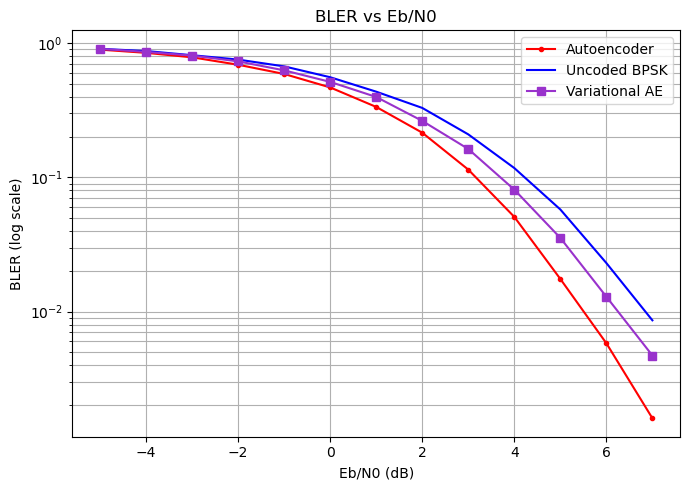

In [357]:
EbN0_dB_range = np.arange(-5, 8, 1)
bler_auto = []
bler_bpsk = []
bler_vae = []
bler_hamm = []  
for snr_db in EbN0_dB_range:
    bler_vae.append(evaluate_bler_vae(snr_db))
    bler_auto.append(evaluate_bler_autoencoder(snr_db))
    bler_bpsk.append(evaluate_bler_bpsk(snr_db))
    bler_hamm.append(evaluate_bler_hamming(snr_db)) 

# --- Plot ---
plt.figure()
plt.semilogy(EbN0_dB_range, bler_auto, marker='.', color='red', label='Autoencoder')


plt.semilogy(EbN0_dB_range, bler_bpsk,color='blue', label='Uncoded BPSK')


plt.semilogy(EbN0_dB_range, bler_vae,marker='s', color='darkorchid', label='Variational AE')

plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BLER (log scale)')
plt.title('BLER vs Eb/N0')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()